# <center> Long-Short Term Memory (LSTM) Neural Network

In [1]:
## Import packages
from math import sqrt
from math import ceil
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
#Import Data, reorganize columns, and remove convolved column
minute = pd.read_excel('ml_dataset.xlsx',sheet_name='Minute', index_col=0, parse_dates=True)
minute = minute[['PC-1', 'PC-2', 'grid']]
hour = pd.read_excel('ml_dataset.xlsx',sheet_name='Hour', index_col=0, parse_dates=True)
hour = hour[['PC-1', 'PC-2', 'grid']]
day = pd.read_excel('ml_dataset.xlsx',sheet_name='Day', index_col=0, parse_dates=True)
day = day[['PC-1', 'PC-2', 'grid']]
week = pd.read_excel('ml_dataset.xlsx',sheet_name='Week', index_col=0, parse_dates=True)
week = week[['PC-1', 'PC-2', 'grid']]
month = pd.read_excel('ml_dataset.xlsx',sheet_name='Month', index_col=0, parse_dates=True)
month = month[['PC-1', 'PC-2', 'grid']]

## Convolved Data was not used for training the neural network to avoid overfitting.

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
    :param data: reframed_dataseries
    :param n_in: Default to 1
    :param n_out: Default to 1
    :param dropnan: boolean to drop na values
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def reframe_data(data):
    """
    :param data: timeseries data
    """
    values = data.values
    # ensure all data is float
    values = values.astype('float32')
    # frame as supervised learning
    reframed = series_to_supervised(values, 1, 1)
    return reframed

In [5]:
def build_train_test(reframed_data, len_train):
    """
    :param reframed_data: reframed data for supervised learning
    :param len_train: training split
    """
    values = reframed_data.values
    train = values[:len_train, :]
    test = values[len_train:, :]   

    # split into input and outputs
    train_x, train_y = train[:, :-1], train[:, -1] 
    test_x, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    print(f'Train X shape: {train_x.shape}, Train Y Shape: {train_y.shape}, Test X Shape: {test_x.shape}, Test Y Shape: {test_y.shape}')
    return train_x, test_x, train_y, test_y

In [6]:
# Design network
def lstm_predict(train_x, test_x, train_y, test_y):
    """
    :param train_x: supervised learning x train
    :param test_x: supervised learning x test
    :param train_y: supervised learning y train
    :param test_y: supervised learning y test
    """
    # Epoch: number of passes over the entire dataset
    # Loss: minimization of error between predicted and actual, calculated after each pass/epoch
    model = Sequential()
    # LSTM layer; 50 neurons in hidden layer 1
    model.add(LSTM(units=50, return_sequences = True, input_shape=(train_x.shape[1], train_x.shape[2])))  
    # Dropout layer; prevents overfitting of training data by randomly omitting neurons; rate=0.2
    model.add(Dropout(0.2))
    # Add 3 more hidden and dropout layers:
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))  # this one will only return final output
    model.add(Dropout(0.2))
    # Dense layer; 1 neuron in output layer
    model.add(Dense(1))  # 1 neuron in output layer
    model.compile(loss='mae', optimizer='adam')  # Mean Absolute Error loss function, 'adam' optimization is efficient stochastic gradient descent

    ## Fit network
    history = model.fit(train_x, train_y, epochs=50, batch_size=72, validation_data=(test_x, test_y), verbose=2, shuffle=False)
    # plot loss history
    plt.plot(history.history['loss'], label='train', c = 'b')
    plt.plot(history.history['val_loss'], label='test', c = 'r')
    plt.title('Train and Testing Loss')
    plt.legend()
    plt.show()
    
    ## Make a prediction
    yhat = model.predict(test_x)
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[2]))

    ## Invert back to original values
    # invert scaling for forecast (inv_yhat)
    inv_yhat = concatenate((yhat, test_x[:, 1:]), axis=1)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual (inv_y)
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
    inv_y = inv_y[:,0]

    # Calculate RMSE; see printed below graph
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
    return inv_y, inv_yhat

In [7]:
def plot_nn(dataset,inv_y, inv_yhat, time_interval):
    """
    :param dataset: original time series dataframe
    :param inv_y: Inverted original signal returned by lstm_predict
    :param inv_yhat: Inverted prediction signal returned by lstm_predict
    :param time_interval: Time series interval
    """
    data = dataset.copy()
    test_split = ceil(len(dataset)/3*2)
    data = data[test_split:]
    data = data[1:len(inv_yhat)+1]
    data['True'] = inv_y
    data['LSTM'] = inv_yhat
    plt.figure(figsize=(15,10))
    plt.plot(data['True'], color='g', label='Actual')
    plt.plot(data['LSTM'], color='b', label='Forecast')
    plt.title('LSTM NN Average Home Load Forecast')
    plt.xlabel(f'{time_interval.title()} intervals (Jan 2016-Dec 2016)')
    plt.ylabel('Normalized Energy Consumption')
    plt.legend()
    plt.show()
    return data

# <center> Monthly Predictions

In [8]:
#Format monthly data, 36 months total
month_reframed = reframe_data(month)
month_x_train, month_x_test, month_y_train, month_y_test = build_train_test(month_reframed, 24)

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Train X shape: (24, 1, 5), Train Y Shape: (24,), Test X Shape: (11, 1, 5), Test Y Shape: (11,)


2022-01-17 14:21:52.173016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
1/1 - 5s - loss: 0.5516 - val_loss: 0.4167 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 0s - loss: 0.5484 - val_loss: 0.4135 - 19ms/epoch - 19ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5451 - val_loss: 0.4102 - 18ms/epoch - 18ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5419 - val_loss: 0.4069 - 16ms/epoch - 16ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5385 - val_loss: 0.4035 - 17ms/epoch - 17ms/step
Epoch 6/50
1/1 - 0s - loss: 0.5354 - val_loss: 0.3999 - 16ms/epoch - 16ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5317 - val_loss: 0.3963 - 17ms/epoch - 17ms/step
Epoch 8/50
1/1 - 0s - loss: 0.5286 - val_loss: 0.3926 - 17ms/epoch - 17ms/step
Epoch 9/50
1/1 - 0s - loss: 0.5242 - val_loss: 0.3887 - 16ms/epoch - 16ms/step
Epoch 10/50
1/1 - 0s - loss: 0.5205 - val_loss: 0.3847 - 17ms/epoch - 17ms/step
Epoch 11/50
1/1 - 0s - loss: 0.5164 - val_loss: 0.3806 - 17ms/epoch - 17ms/step
Epoch 12/50
1/1 - 0s - loss: 0.5121 - val_loss: 0.3763 - 17ms/epoch - 17ms/step
Epoch 13/50
1/1 - 0s - loss: 0.5070 - val_loss: 0.371

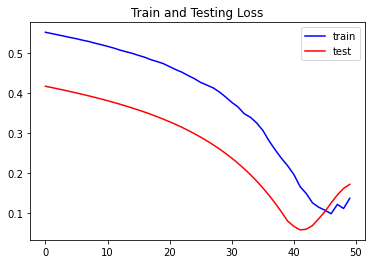

Test RMSE: 0.183


In [9]:
#Monthly Forecasting
month_actual, month_predict = lstm_predict(month_x_train, month_x_test, month_y_train, month_y_test)

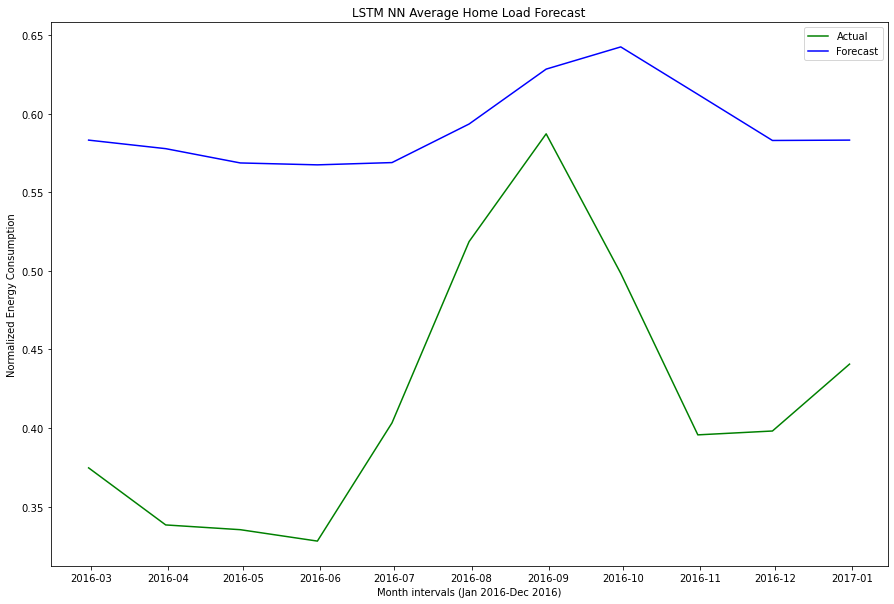

In [10]:
#Plot Monthly Forecast
month_nn = plot_nn(month,month_actual, month_predict, 'Month')

# <center> Week Predictions

In [11]:
#Format weekly data, 157 weeks total
week_reframed = reframe_data(week)
week_x_train, week_x_test, week_y_train, week_y_test = build_train_test(week_reframed, 105)

Train X shape: (105, 1, 5), Train Y Shape: (105,), Test X Shape: (51, 1, 5), Test Y Shape: (51,)


Epoch 1/50
2/2 - 5s - loss: 0.5517 - val_loss: 0.4116 - 5s/epoch - 2s/step
Epoch 2/50
2/2 - 0s - loss: 0.5449 - val_loss: 0.4047 - 22ms/epoch - 11ms/step
Epoch 3/50
2/2 - 0s - loss: 0.5381 - val_loss: 0.3975 - 21ms/epoch - 10ms/step
Epoch 4/50
2/2 - 0s - loss: 0.5308 - val_loss: 0.3898 - 21ms/epoch - 10ms/step
Epoch 5/50
2/2 - 0s - loss: 0.5227 - val_loss: 0.3816 - 21ms/epoch - 11ms/step
Epoch 6/50
2/2 - 0s - loss: 0.5145 - val_loss: 0.3728 - 21ms/epoch - 11ms/step
Epoch 7/50
2/2 - 0s - loss: 0.5052 - val_loss: 0.3632 - 21ms/epoch - 11ms/step
Epoch 8/50
2/2 - 0s - loss: 0.4953 - val_loss: 0.3527 - 21ms/epoch - 10ms/step
Epoch 9/50
2/2 - 0s - loss: 0.4841 - val_loss: 0.3413 - 21ms/epoch - 10ms/step
Epoch 10/50
2/2 - 0s - loss: 0.4732 - val_loss: 0.3286 - 21ms/epoch - 10ms/step
Epoch 11/50
2/2 - 0s - loss: 0.4593 - val_loss: 0.3146 - 21ms/epoch - 10ms/step
Epoch 12/50
2/2 - 0s - loss: 0.4458 - val_loss: 0.2989 - 20ms/epoch - 10ms/step
Epoch 13/50
2/2 - 0s - loss: 0.4296 - val_loss: 0.281

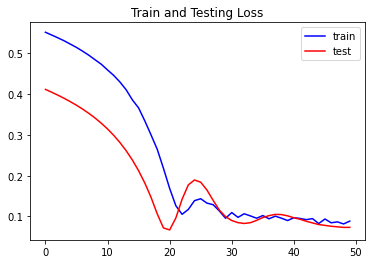

Test RMSE: 0.089


In [12]:
#Weekly Forecast
week_actual, week_predict = lstm_predict(week_x_train, week_x_test, week_y_train, week_y_test)

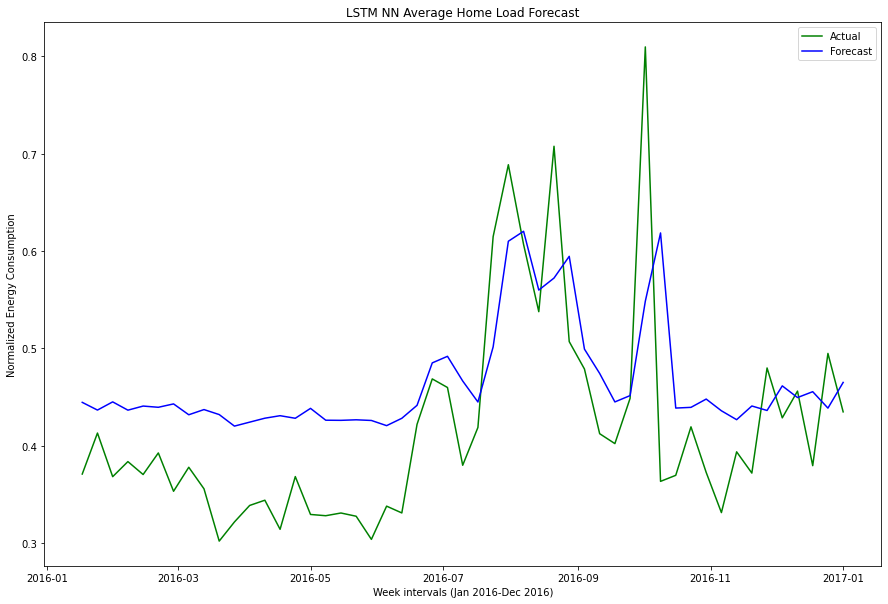

In [13]:
#Plot Weekly Forecast
week_nn = plot_nn(week,week_actual, week_predict, 'Week')

# <center> Daily Predictions

In [14]:
#Format daily data, 1096 days total
day_reframed = reframe_data(day)
day_x_train, day_x_test, day_y_train, day_y_test = build_train_test(day_reframed, 731)

Train X shape: (731, 1, 5), Train Y Shape: (731,), Test X Shape: (364, 1, 5), Test Y Shape: (364,)


Epoch 1/50
11/11 - 5s - loss: 0.5371 - val_loss: 0.3757 - 5s/epoch - 428ms/step
Epoch 2/50
11/11 - 0s - loss: 0.4864 - val_loss: 0.3105 - 60ms/epoch - 5ms/step
Epoch 3/50
11/11 - 0s - loss: 0.3993 - val_loss: 0.1873 - 58ms/epoch - 5ms/step
Epoch 4/50
11/11 - 0s - loss: 0.2243 - val_loss: 0.1110 - 58ms/epoch - 5ms/step
Epoch 5/50
11/11 - 0s - loss: 0.1262 - val_loss: 0.1438 - 57ms/epoch - 5ms/step
Epoch 6/50
11/11 - 0s - loss: 0.1201 - val_loss: 0.0866 - 57ms/epoch - 5ms/step
Epoch 7/50
11/11 - 0s - loss: 0.1104 - val_loss: 0.1013 - 57ms/epoch - 5ms/step
Epoch 8/50
11/11 - 0s - loss: 0.1082 - val_loss: 0.0988 - 58ms/epoch - 5ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0956 - val_loss: 0.0868 - 58ms/epoch - 5ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0887 - val_loss: 0.0809 - 54ms/epoch - 5ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0844 - val_loss: 0.0698 - 55ms/epoch - 5ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0801 - val_loss: 0.0629 - 56ms/epoch - 5ms/step
Epoch 13/50
11/11 - 0s - loss: 0.0812

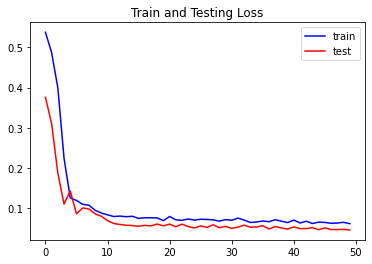

Test RMSE: 0.056


In [15]:
#Daily Forecast
day_actual, day_predict = lstm_predict(day_x_train, day_x_test, day_y_train, day_y_test)

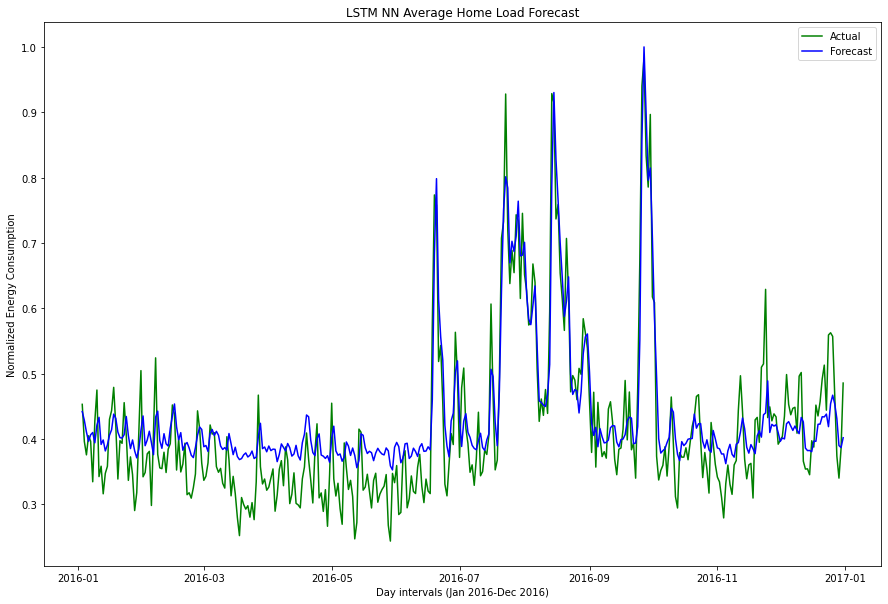

In [16]:
#Plot Daily Forecast
day_nn = plot_nn(day,day_actual, day_predict, 'Day')

# <center> Hourly Predictions

In [17]:
#Format Hourly Data, 26304 hours total
hour_reframed = reframe_data(hour)
hour_x_train, hour_x_test, hour_y_train, hour_y_test = build_train_test(hour_reframed, 17536)

Train X shape: (17536, 1, 5), Train Y Shape: (17536,), Test X Shape: (8761, 1, 5), Test Y Shape: (8761,)


Epoch 1/50
244/244 - 5s - loss: 0.1740 - val_loss: 0.0973 - 5s/epoch - 22ms/step
Epoch 2/50
244/244 - 1s - loss: 0.0945 - val_loss: 0.0767 - 927ms/epoch - 4ms/step
Epoch 3/50
244/244 - 1s - loss: 0.0786 - val_loss: 0.0671 - 942ms/epoch - 4ms/step
Epoch 4/50
244/244 - 1s - loss: 0.0730 - val_loss: 0.0656 - 924ms/epoch - 4ms/step
Epoch 5/50
244/244 - 1s - loss: 0.0712 - val_loss: 0.0664 - 938ms/epoch - 4ms/step
Epoch 6/50
244/244 - 1s - loss: 0.0700 - val_loss: 0.0653 - 928ms/epoch - 4ms/step
Epoch 7/50
244/244 - 1s - loss: 0.0690 - val_loss: 0.0648 - 897ms/epoch - 4ms/step
Epoch 8/50
244/244 - 1s - loss: 0.0678 - val_loss: 0.0648 - 901ms/epoch - 4ms/step
Epoch 9/50
244/244 - 1s - loss: 0.0682 - val_loss: 0.0650 - 907ms/epoch - 4ms/step
Epoch 10/50
244/244 - 1s - loss: 0.0676 - val_loss: 0.0638 - 929ms/epoch - 4ms/step
Epoch 11/50
244/244 - 1s - loss: 0.0665 - val_loss: 0.0648 - 914ms/epoch - 4ms/step
Epoch 12/50
244/244 - 1s - loss: 0.0668 - val_loss: 0.0638 - 900ms/epoch - 4ms/step
Epo

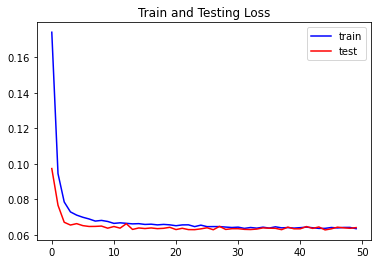

Test RMSE: 0.089


In [18]:
#Hourly Forecast
hour_actual, hour_predict = lstm_predict(hour_x_train, hour_x_test, hour_y_train, hour_y_test)

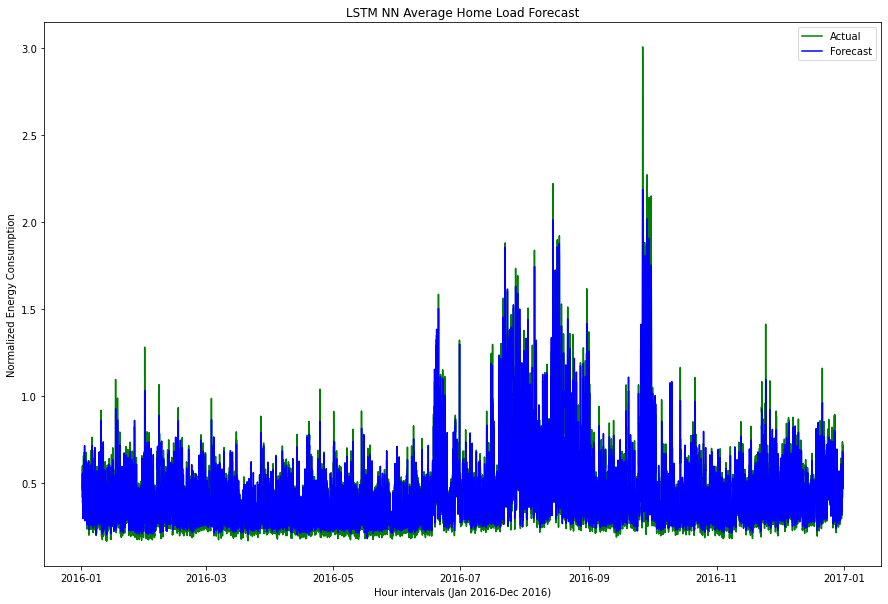

In [19]:
#Plot Hourly Forecast
hour_nn = plot_nn(hour,hour_actual, hour_predict, 'Hour')

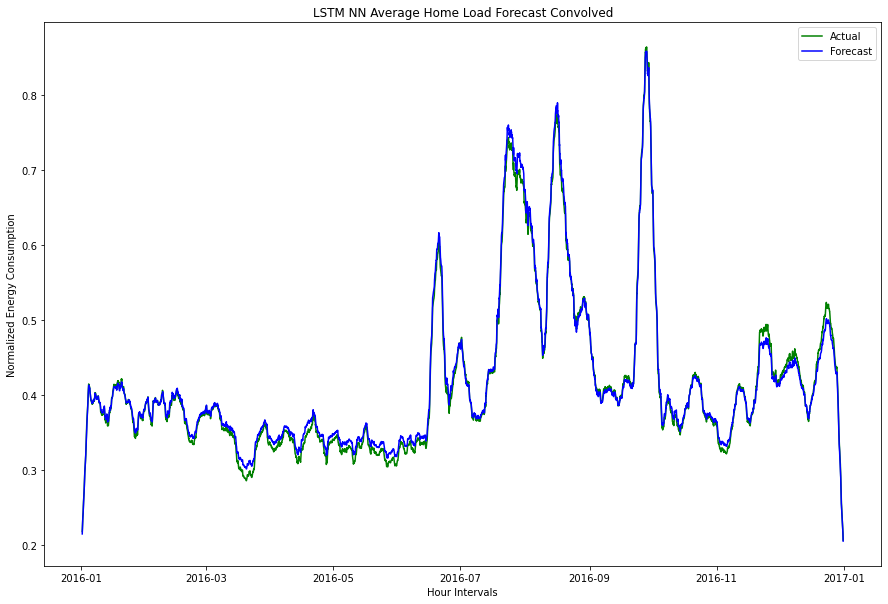

In [20]:
#Convolve Hour Forecast and plot
kernel_size = 12*12
kernel = np.ones(kernel_size) / kernel_size
hour_convolved = np.convolve(hour_actual, kernel, mode='same')
hour_predict_convolved = np.convolve(hour_predict, kernel, mode='same')

hour_set = hour.copy()
hour_set = hour_set[ceil(len(hour)/3*2):]
hour_set = hour_set[:len(hour_predict)]
hour_set['convolved'] = hour_convolved
hour_set['predict'] = hour_predict_convolved

hour_nn['convolved'] = hour_set['convolved']
hour_nn['convolved lstm'] = hour_set['predict']

plt.figure(figsize=(15,10))
plt.plot(hour_set['convolved'], color='g', label='Actual')
plt.plot(hour_set['predict'], color='b', label='Forecast')
plt.title('LSTM NN Average Home Load Forecast Convolved')
plt.xlabel('Hour Intervals')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.show()

# <center> 15-Minute Predictions

In [21]:
#Format 15-minute data, 105204 total datapoints
minute_reframed = reframe_data(minute)
minute_x_train, minute_x_test, minute_y_train, minute_y_test = build_train_test(minute_reframed, 70136)

Train X shape: (70136, 1, 5), Train Y Shape: (70136,), Test X Shape: (35067, 1, 5), Test Y Shape: (35067,)


Epoch 1/50
975/975 - 8s - loss: 0.0874 - val_loss: 0.0477 - 8s/epoch - 8ms/step
Epoch 2/50
975/975 - 3s - loss: 0.0596 - val_loss: 0.0484 - 3s/epoch - 4ms/step
Epoch 3/50
975/975 - 4s - loss: 0.0574 - val_loss: 0.0455 - 4s/epoch - 4ms/step
Epoch 4/50
975/975 - 4s - loss: 0.0563 - val_loss: 0.0460 - 4s/epoch - 4ms/step
Epoch 5/50
975/975 - 4s - loss: 0.0555 - val_loss: 0.0473 - 4s/epoch - 4ms/step
Epoch 6/50
975/975 - 4s - loss: 0.0550 - val_loss: 0.0470 - 4s/epoch - 4ms/step
Epoch 7/50
975/975 - 4s - loss: 0.0545 - val_loss: 0.0468 - 4s/epoch - 4ms/step
Epoch 8/50
975/975 - 4s - loss: 0.0542 - val_loss: 0.0458 - 4s/epoch - 4ms/step
Epoch 9/50
975/975 - 4s - loss: 0.0542 - val_loss: 0.0473 - 4s/epoch - 4ms/step
Epoch 10/50
975/975 - 4s - loss: 0.0540 - val_loss: 0.0482 - 4s/epoch - 4ms/step
Epoch 11/50
975/975 - 4s - loss: 0.0537 - val_loss: 0.0462 - 4s/epoch - 4ms/step
Epoch 12/50
975/975 - 4s - loss: 0.0537 - val_loss: 0.0489 - 4s/epoch - 4ms/step
Epoch 13/50
975/975 - 4s - loss: 0.05

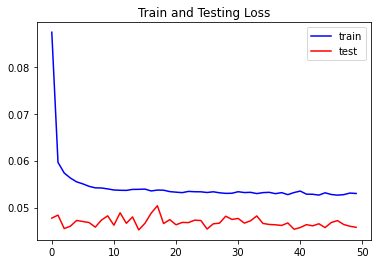

Test RMSE: 0.069


In [22]:
#15-Minute forecast
minute_actual, minute_predict = lstm_predict(minute_x_train, minute_x_test, minute_y_train, minute_y_test)

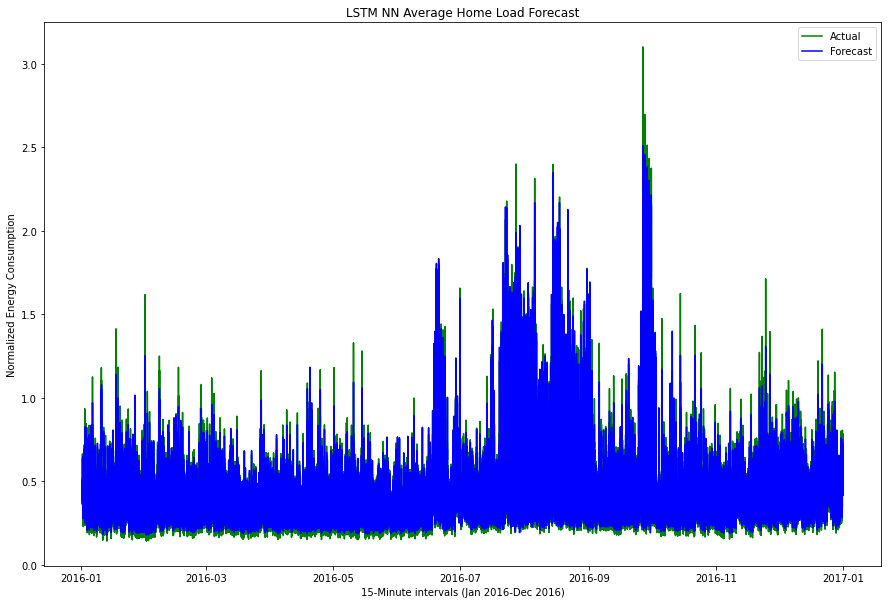

In [23]:
#Plot 15-minute Forecast
minute_nn = plot_nn(minute,minute_actual, minute_predict, '15-Minute')

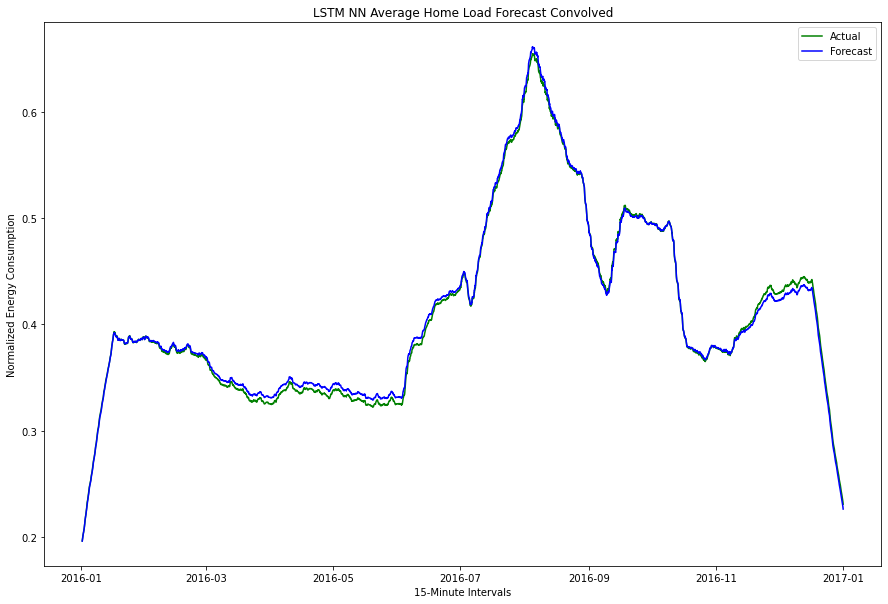

In [24]:
#Convole 15-minute forecast and plot
kernel_size = 4*24*30
kernel = np.ones(kernel_size) / kernel_size
minute_convolved = np.convolve(minute_actual, kernel, mode='same')
minute_predict_convolved = np.convolve(minute_predict, kernel, mode='same')

min_set = minute.copy()
min_set = min_set[ceil(len(minute)/3*2):]
min_set = min_set[:len(minute_predict)]
min_set['convolved'] = minute_convolved
min_set['predict'] = minute_predict_convolved

minute_nn['convolved'] = min_set['convolved']
minute_nn['convolved lstm'] = min_set['predict']

plt.figure(figsize=(15,10))
plt.plot(min_set['convolved'], color='g', label='Actual')
plt.plot(min_set['predict'], color='b', label='Forecast')
plt.title('LSTM NN Average Home Load Forecast Convolved')
plt.xlabel('15-Minute Intervals')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.show()